# Demo for PAO-ML via e3nn

See also https://docs.e3nn.org/en/latest/guide/convolution.html

## Requirements:
```
pip install --upgrade e3nn torch_cluster torch_scatter matplotlib
```

In [1]:
from pao_file_utils import parse_pao_file, write_pao_file, read_cp2k_energy
import torch
from e3nn import o3, nn
from e3nn.math import soft_one_hot_linspace
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings
t = torch.tensor

In [2]:
# Convenient wrapper that returns torch Tensors
def parse_pao_file_torch(path: Path):
    kinds, atom2kind, coords, xblocks = parse_pao_file(path)
    return kinds, atom2kind, t(coords, dtype=torch.float32), [t(x, dtype=torch.float32) for x in xblocks]

In [3]:
# Load single training sample.
kinds, atom2kind, coords, xblocks = parse_pao_file_torch(Path("./2H2O_rotations/phi_00/2H2O_pao44-1_0.pao"))

In [4]:
# We are going over-fit the model by training only on a single sample of a single atom.
TRAINING_ATOM = 0 # The atom on which we're training.

In [5]:
# Irreps Input
irreps_input = o3.Irreps("2x0e") # features: is_hydrogen, is_oxygen

In [6]:
# Irreps Output
pao_basis_size = 4
prim_basis_specs = {
    "O": "2x0e + 2x1o + 1x2e", # DZVP-MOLOPT-GTH for Oxygen: two s-shells, two p-shells, one d-shell
    "H": "2x0e + 1x1o" # DZVP-MOLOPT-GTH for Hydrogen: two s-shells, one p-shell
}
prim_basis_spec = prim_basis_specs[atom2kind[TRAINING_ATOM]]
prim_basis_size = o3.Irreps(prim_basis_spec).dim
irreps_output = o3.Irreps(" + ".join(pao_basis_size*[prim_basis_spec]))
assert irreps_output.dim == xblocks[TRAINING_ATOM].flatten().size(0)

In [7]:
# Irreps Spherical Harmonics
irreps_sh = o3.Irreps.spherical_harmonics(lmax=2)

40


(<Figure size 640x480 with 1 Axes>, <Axes: >)

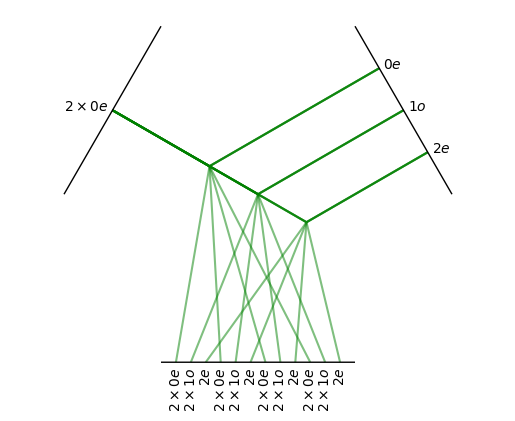

In [8]:
# Tensor Product
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    tp = o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_output, shared_weights=False)
print(tp.weight_numel)
tp.visualize()

In [9]:
# Perceptron
num_distances = 10
num_layers = 16
fc = nn.FullyConnectedNet([num_distances, num_layers, tp.weight_numel], torch.relu)
print("Number of parameters: ", sum(p.numel() for p in fc.parameters()))

Number of parameters:  800


In [10]:
# The input of each node is whether it's an oxygen or not.
num_neighbors = 6 # TODO: Remove the central atom, it doesn't carry any information.
f_in = t([(k=="H", k=="O") for k in atom2kind], dtype=torch.float32).mul(num_neighbors**0.5)
assert f_in.shape[0] == num_neighbors and f_in.shape[1] == irreps_input.dim

In [11]:
# CP2K uses the yzx convention, while e3nn uses xyz.
# https://docs.e3nn.org/en/stable/guide/change_of_basis.html
change_of_coord = torch.tensor([[0., 0., 1.],[1., 0., 0.],[0., 1., 0.]]) # yzx -> xyz
D = irreps_output.D_from_matrix(change_of_coord)

In [12]:
# Preprocessing, model, and loss functions.
max_radius = 4

def edge_vec(coords):
    assert coords.shape[0] == num_neighbors
    return coords - coords[TRAINING_ATOM]

def normalize(xblock):
    return xblock / torch.norm(xblock, dim=1)[:,None]

def labelfy(xblocks):
    return normalize(xblocks[TRAINING_ATOM])

# def regularization(label):
#     return 0.1 * (1 - torch.norm(label, dim=1)).pow(2).sum()

# def loss_function(pred, label):
#     assert regularization(label).item() < 1e-8
#     projector1 = pred.T @ pred
#     projector2 = label.T @ label # assumes normalized label
#     residual = projector1 - projector2 @ projector1
#     return residual.pow(2).sum() + regularization(pred)

def model(edge_vec):
    sh = o3.spherical_harmonics(irreps_sh, edge_vec, normalize=True, normalization='component')
    emb = soft_one_hot_linspace(edge_vec.norm(dim=1), 0.0, max_radius, num_distances,
                                basis='smooth_finite', cutoff=True).mul(num_distances**0.5)
    flat_xyz = tp(f_in, sh, fc(emb)).sum(dim=0).div(num_neighbors**0.5)
    flat_yzx = flat_xyz @ D
    return flat_yzx.reshape(pao_basis_size, prim_basis_size)

In [13]:
# Train the model.
optim = torch.optim.Adam(fc.parameters(), lr=1e-3)
label = labelfy(xblocks)

for step in range(30001):
    pred = model(edge_vec(coords))
    loss = (pred - label).pow(2).sum()
    # TODO Find better loss function.
    # loss = loss_function(pred, label)
        
    optim.zero_grad()
    loss.backward()
    optim.step()

    if step % 1000 == 0:
        print(f"epoch {step:5d} | loss {loss:.1e}")

epoch     0 | loss 9.2e+01
epoch  1000 | loss 1.4e+00
epoch  2000 | loss 9.9e-01
epoch  3000 | loss 9.7e-01
epoch  4000 | loss 9.6e-01
epoch  5000 | loss 9.5e-01
epoch  6000 | loss 9.3e-01
epoch  7000 | loss 9.0e-01
epoch  8000 | loss 8.5e-01
epoch  9000 | loss 7.8e-01
epoch 10000 | loss 6.6e-01
epoch 11000 | loss 5.2e-01
epoch 12000 | loss 3.7e-01
epoch 13000 | loss 2.3e-01
epoch 14000 | loss 1.2e-01
epoch 15000 | loss 5.1e-02
epoch 16000 | loss 1.5e-02
epoch 17000 | loss 3.1e-03
epoch 18000 | loss 3.9e-04
epoch 19000 | loss 4.3e-05
epoch 20000 | loss 1.3e-04
epoch 21000 | loss 8.9e-06
epoch 22000 | loss 1.3e-05
epoch 23000 | loss 2.0e-05
epoch 24000 | loss 3.1e-05
epoch 25000 | loss 8.9e-06
epoch 26000 | loss 9.0e-06
epoch 27000 | loss 9.3e-06
epoch 28000 | loss 8.9e-06
epoch 29000 | loss 8.7e-06
epoch 30000 | loss 8.9e-06


In [14]:
# Test against randomly rotated training samples using CP2K.
for path in sorted(Path().glob("2H2O_rotations/rand_*/2H2O_pao44-1_0.pao")):
    _, _, sample_coords, sample_xblocks = parse_pao_file_torch(path)
    pred_xblocks = sample_xblocks.copy()
    pred_xblocks[TRAINING_ATOM] = model(edge_vec(sample_coords))
    write_pao_file(path.parent / "2H2O_pao44_eval.pao", kinds, atom2kind, sample_coords, pred_xblocks)
    ! cd {path.parent}; OMP_NUM_THREADS=8 ~/git/cp2k/exe/local/cp2k.sdbg 2H2O_pao44_eval.inp > 2H2O_pao44_eval.out
    test_energy = read_cp2k_energy(path.parent / "2H2O_pao44_eval.out")
    ref_energy = read_cp2k_energy(path.parent / "2H2O_pao44.out")
    rel_diff_energy = (test_energy - ref_energy) / ref_energy
    print(f"{path}: Relative Energy Diff: {rel_diff_energy:e}")

2H2O_rotations/rand_00/2H2O_pao44-1_0.pao: Relative Energy Diff: -5.356019e-07
2H2O_rotations/rand_01/2H2O_pao44-1_0.pao: Relative Energy Diff: -4.864737e-07
2H2O_rotations/rand_02/2H2O_pao44-1_0.pao: Relative Energy Diff: -6.410069e-07
2H2O_rotations/rand_03/2H2O_pao44-1_0.pao: Relative Energy Diff: -4.721108e-07
2H2O_rotations/rand_04/2H2O_pao44-1_0.pao: Relative Energy Diff: -6.689047e-07
2H2O_rotations/rand_05/2H2O_pao44-1_0.pao: Relative Energy Diff: -5.798472e-07
2H2O_rotations/rand_06/2H2O_pao44-1_0.pao: Relative Energy Diff: -5.385417e-07
2H2O_rotations/rand_07/2H2O_pao44-1_0.pao: Relative Energy Diff: -6.004738e-07
2H2O_rotations/rand_08/2H2O_pao44-1_0.pao: Relative Energy Diff: -6.124662e-07
2H2O_rotations/rand_09/2H2O_pao44-1_0.pao: Relative Energy Diff: -6.114590e-07
2H2O_rotations/rand_10/2H2O_pao44-1_0.pao: Relative Energy Diff: -4.676873e-07
2H2O_rotations/rand_11/2H2O_pao44-1_0.pao: Relative Energy Diff: -5.300140e-07
2H2O_rotations/rand_12/2H2O_pao44-1_0.pao: Relative 